# World Bank API Analysis

Pregunta guía: **¿Qué países mejoraron más su esperanza de vida en 2010-2024 y cómo se relaciona con su PIB per cápita?**

## Plan del análisis

- Países: `USA`, `DEU`, `CHN`, `BRA`, `NGA`, `ARG`, `VEN`
- Indicadores: esperanza de vida, PIB per cápita y población
- Rango temporal: 2010 a 2024

In [57]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

sns.set_theme(style="whitegrid")

BASE_URL = "https://api.worldbank.org/v2"
COUNTRIES = ["USA", "DEU", "CHN", "BRA", "NGA", "ARG", "VEN"]
YEARS = (2010, 2024)

INDICATORS = {
    "life_expectancy": "SP.DYN.LE00.IN",
    "gdp_per_capita": "NY.GDP.PCAP.CD",
    "population": "SP.POP.TOTL"
}

In [58]:
def fetch_indicator_data(indicator_code, countries, start_year=2010, end_year=2024, per_page=50, verbose=False):
    country_str = ";".join(countries)
    url = f"{BASE_URL}/country/{country_str}/indicator/{indicator_code}"
    page = 1
    total_pages = 1
    rows = []

    while page <= total_pages:
        params = {
            "format": "json",
            "per_page": per_page,
            "date": f"{start_year}:{end_year}",
            "page": page
        }

        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        payload = response.json()

        if not isinstance(payload, list) or len(payload) < 2 or payload[1] is None:
            break

        metadata = payload[0]
        total_pages = int(metadata.get("pages", 1))
        if verbose:
            print(f"{indicator_code}: pagina {page}/{total_pages}")

        for item in payload[1]:
            year = int(item["date"])
            rows.append({
                "country": item["country"]["value"],
                "countryiso3code": item["countryiso3code"],
                "year": year,
                "value": item["value"],
                "indicator_code": indicator_code
            })

        page += 1

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df.dropna(subset=["value"]).copy()
    df = df.sort_values(["countryiso3code", "year"]).reset_index(drop=True)
    return df

In [59]:
dfs = {}
for name, code in INDICATORS.items():
    dfs[name] = fetch_indicator_data(code, COUNTRIES, YEARS[0], YEARS[1], 50, True)
    print(name, dfs[name].shape)

df_life = dfs["life_expectancy"]
df_gdp = dfs["gdp_per_capita"]
df_pop = dfs["population"]

df_life.head()

SP.DYN.LE00.IN: pagina 1/3
SP.DYN.LE00.IN: pagina 2/3
SP.DYN.LE00.IN: pagina 3/3
life_expectancy (98, 5)
NY.GDP.PCAP.CD: pagina 1/3
NY.GDP.PCAP.CD: pagina 2/3
NY.GDP.PCAP.CD: pagina 3/3
gdp_per_capita (105, 5)
SP.POP.TOTL: pagina 1/3
SP.POP.TOTL: pagina 2/3
SP.POP.TOTL: pagina 3/3
population (105, 5)


,country,countryiso3code,year,value,indicator_code
0,Argentina,ARG,2010,75.680,SP.DYN.LE00.IN
1,Argentina,ARG,2011,76.100,SP.DYN.LE00.IN
2,Argentina,ARG,2012,75.802,SP.DYN.LE00.IN
3,Argentina,ARG,2013,75.829,SP.DYN.LE00.IN
4,Argentina,ARG,2014,76.268,SP.DYN.LE00.IN


## Cambio de esperanza de vida (2010 vs último año disponible común)

In [60]:
start_year = YEARS[0]
end_year_common = int(df_life.groupby("countryiso3code")["year"].max().min())
print(f"Año inicial: {start_year} | Último año común: {end_year_common}")

life_start = (
    df_life[df_life["year"] == start_year][["countryiso3code", "value"]]
    .rename(columns={"value": f"life_{start_year}"})
)

life_end = (
    df_life[df_life["year"] == end_year_common][["countryiso3code", "country", "value"]]
    .rename(columns={"value": f"life_{end_year_common}"})
)

life_change = life_end.merge(life_start, on="countryiso3code", how="inner")
life_change["life_change"] = life_change[f"life_{end_year_common}"] - life_change[f"life_{start_year}"]
life_change = life_change.sort_values("life_change", ascending=False).reset_index(drop=True)

life_change

Año inicial: 2010 | Último año común: 2023


,countryiso3code,country,life_2023,life_2010,life_change
0,NGA,Nigeria,54.462000,51.315000,3.147000
1,CHN,China,77.953000,75.668000,2.285000
2,BRA,Brazil,75.848000,73.779000,2.069000
3,ARG,Argentina,77.395000,75.680000,1.715000
4,DEU,Germany,80.541463,79.987805,0.553659
5,USA,United States,78.385366,78.541463,-0.156098
6,VEN,"Venezuela, RB",72.514000,73.092000,-0.578000


In [61]:
life_end

,countryiso3code,country,life_2023
13,ARG,Argentina,77.395000
27,BRA,Brazil,75.848000
41,CHN,China,77.953000
55,DEU,Germany,80.541463
69,NGA,Nigeria,54.462000
83,USA,United States,78.385366
97,VEN,"Venezuela, RB",72.514000


## Relación con PIB per cápita (2010 vs 2023)

In [62]:
gdp_start_year = 2010
gdp_end_year = 2023

gdp_start = (
    df_gdp[df_gdp["year"] == gdp_start_year][["countryiso3code", "value"]]
    .rename(columns={"value": f"gdp_pc_{gdp_start_year}"})
)

gdp_end = (
    df_gdp[df_gdp["year"] == gdp_end_year][["countryiso3code", "value"]]
    .rename(columns={"value": f"gdp_pc_{gdp_end_year}"})
)

gdp_compare = gdp_start.merge(gdp_end, on="countryiso3code", how="inner")
gdp_compare["gdp_change_2010_2023"] = gdp_compare[f"gdp_pc_{gdp_end_year}"] - gdp_compare[f"gdp_pc_{gdp_start_year}"]

analysis_df = life_change.merge(gdp_compare, on="countryiso3code", how="left")
analysis_df = analysis_df[["country", "countryiso3code", f"life_{start_year}", f"life_{end_year_common}", "life_change", f"gdp_pc_{gdp_start_year}", f"gdp_pc_{gdp_end_year}", "gdp_change_2010_2023"]]
analysis_df.sort_values("life_change", ascending=False)

,country,countryiso3code,life_2010,life_2023,life_change,gdp_pc_2010,gdp_pc_2023,gdp_change_2010_2023
0,Nigeria,NGA,51.315000,54.462000,3.147000,2202.256730,2138.763837,-63.492892
1,China,CHN,75.668000,77.953000,2.285000,4629.245517,12951.178240,8321.932723
2,Brazil,BRA,73.779000,75.848000,2.069000,11403.284004,10377.589772,-1025.694232
3,Argentina,ARG,75.680000,77.395000,1.715000,10260.131311,14261.846567,4001.715256
4,Germany,DEU,79.987805,80.541463,0.553659,42396.966598,54776.766824,12379.800226
5,United States,USA,78.541463,78.385366,-0.156098,48642.610018,81032.262118,32389.652100
6,"Venezuela, RB",VEN,73.092000,72.514000,-0.578000,13646.304662,3617.435946,-10028.868716


## Visualización 1: evolución de esperanza de vida

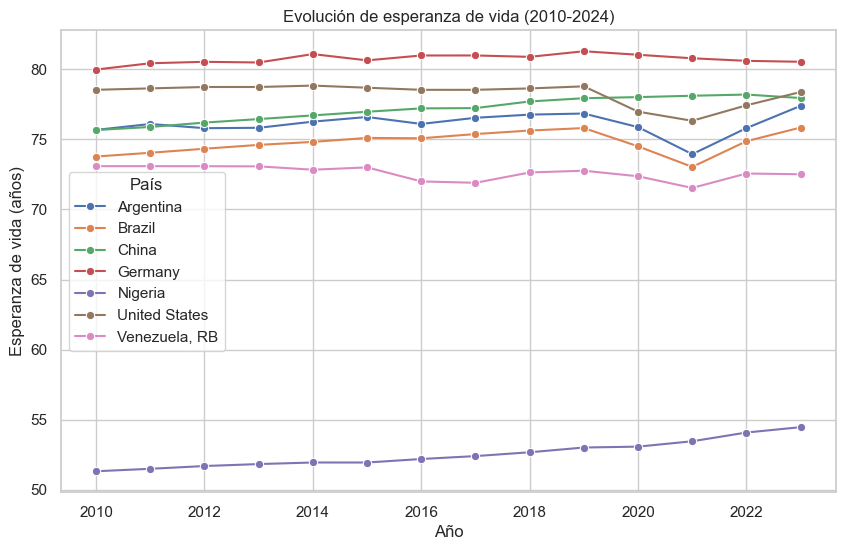

In [63]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_life, x="year", y="value", hue="country", marker="o")
plt.title("Evolución de esperanza de vida (2010-2024)")
plt.xlabel("Año")
plt.ylabel("Esperanza de vida (años)")
plt.legend(title="País")
plt.show()

## Visualización bonus: evolución del PIB per cápita (2010-2023)

Esta visualización complementa la de esperanza de vida y permite ver la trayectoria anual del PIB per cápita en cada país.


In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_gdp, x="year", y="value", hue="country", marker="o")
plt.title("Evolución del PIB per cápita (2010-2023)")
plt.xlabel("Año")
plt.ylabel("PIB per cápita (USD corrientes)")
plt.legend(title="País", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Visualización 2: mejora en esperanza de vida vs PIB per cápita

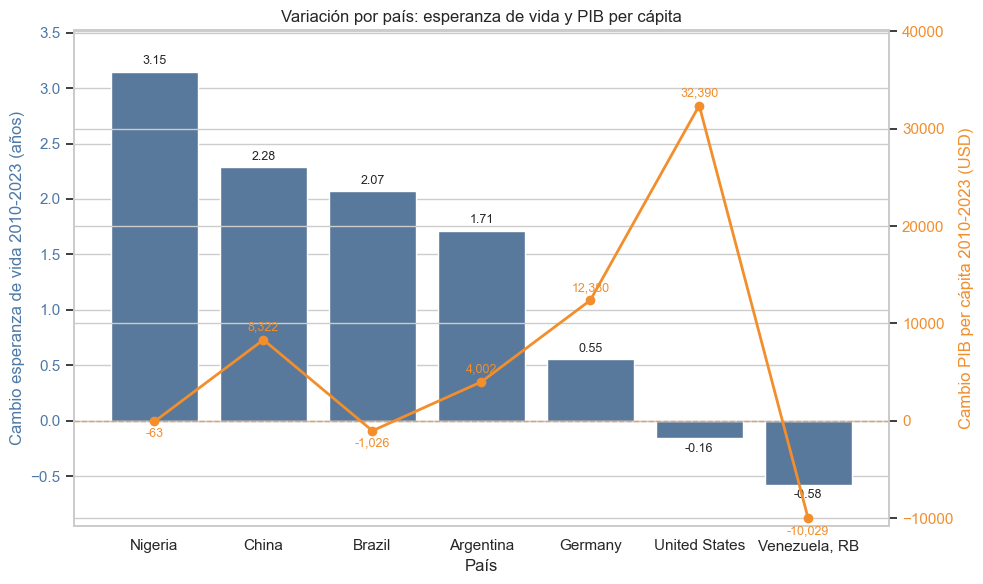

In [64]:
plot_df = analysis_df.sort_values("life_change", ascending=False).copy()
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(data=plot_df, x="country", y="life_change", color="#4E79A7", ax=ax1)
ax1.set_title("Variación por país: esperanza de vida y PIB per cápita")
ax1.set_xlabel("País")
ax1.set_ylabel(f"Cambio esperanza de vida {start_year}-{end_year_common} (años)", color="#4E79A7")
ax1.tick_params(axis="y", labelcolor="#4E79A7")

# Eje izquierdo: incluir cero con margen y mantener legibilidad.
life_values = plot_df["life_change"]
life_min = float(life_values.min())
life_max = float(life_values.max())
life_pad = max(0.15, (life_max - life_min) * 0.10)
y1_min = min(life_min - life_pad, 0 - life_pad)
y1_max = max(life_max + life_pad, 0 + life_pad)
ax1.set_ylim(y1_min, y1_max)

for i, value in enumerate(life_values):
    y = value + 0.04 if value >= 0 else value - 0.04
    va = "bottom" if value >= 0 else "top"
    ax1.text(i, y, f"{value:.2f}", ha="center", va=va, fontsize=9)

ax2 = ax1.twinx()
gdp_values = plot_df["gdp_change_2010_2023"]
ax2.plot(plot_df["country"], gdp_values, color="#F28E2B", marker="o", linewidth=2)
ax2.set_ylabel("Cambio PIB per cápita 2010-2023 (USD)", color="#F28E2B")
ax2.tick_params(axis="y", labelcolor="#F28E2B")
ax2.axhline(0, color="#F28E2B", linestyle="--", linewidth=1, alpha=0.7)

# Alinea el 0 del eje derecho con el 0 del eje izquierdo.
gdp_min = float(gdp_values.min())
gdp_max = float(gdp_values.max())
zero_pos_left = (0 - y1_min) / (y1_max - y1_min)
span_needed = max(gdp_max / max(1e-9, (1 - zero_pos_left)), -gdp_min / max(1e-9, zero_pos_left))
span = span_needed * 1.08
y2_min = -zero_pos_left * span
y2_max = (1 - zero_pos_left) * span
ax2.set_ylim(y2_min, y2_max)

offset = max(abs(gdp_min), abs(gdp_max)) * 0.02
for i, value in enumerate(gdp_values):
    y = value + offset if value >= 0 else value - offset
    va = "bottom" if value >= 0 else "top"
    ax2.text(i, y, f"{value:,.0f}", color="#F28E2B", ha="center", va=va, fontsize=9)

fig.tight_layout()
plt.show()

## Hallazgos finales (muestra ampliada a 7 países)

Con la incorporación de **Argentina (ARG)** y **Venezuela (VEN)**, el análisis gana contraste y permite ver mejor que la relación entre ingreso y salud no siempre es lineal.

### 1) Esperanza de vida (2010-2023)

- Mejoras más altas: **Nigeria (+3.15)**, **China (+2.28)** y **Brasil (+2.07)**.
- Mejora intermedia: **Argentina (+1.71)**.
- Mejora baja: **Alemania (+0.55)**.
- Caídas: **Estados Unidos (-0.16)** y **Venezuela (-0.58)**.

### 2) PIB per cápita (2010-2023, USD corrientes)

- Aumentos: **Estados Unidos (+32,390)**, **Alemania (+12,380)**, **China (+8,322)**, **Argentina (+4,002)**.
- Caídas: **Venezuela (-10,029)**, **Brasil (-1,026)**, **Nigeria (-63)**.

### 3) Conclusión para entrega

En conjunto, los resultados muestran que existe relación entre la evolución del PIB per cápita y la esperanza de vida, pero no de forma lineal ni automática. El crecimiento económico puede acompañar mejoras en salud, aunque su impacto depende de cómo se distribuye el ingreso y de la calidad de las políticas públicas, los sistemas sanitarios y las condiciones sociales. Por eso, para interpretar cambios en esperanza de vida, es necesario considerar el contexto integral de cada país y no solo la variación de su ingreso promedio.

## Carga a SQLite

In [65]:
engine = create_engine("sqlite:///world_bank_analysis.db")

df_life.to_sql("indicator_life_expectancy", con=engine, if_exists="replace", index=False)
df_gdp.to_sql("indicator_gdp_per_capita", con=engine, if_exists="replace", index=False)
df_pop.to_sql("indicator_population", con=engine, if_exists="replace", index=False)
analysis_df.to_sql("analysis_life_vs_gdp", con=engine, if_exists="replace", index=False)

pd.read_sql("SELECT * FROM analysis_life_vs_gdp LIMIT 5", con=engine)

,country,countryiso3code,life_2010,life_2023,life_change,gdp_pc_2010,gdp_pc_2023,gdp_change_2010_2023
0,Nigeria,NGA,51.315000,54.462000,3.147000,2202.256730,2138.763837,-63.492892
1,China,CHN,75.668000,77.953000,2.285000,4629.245517,12951.178240,8321.932723
2,Brazil,BRA,73.779000,75.848000,2.069000,11403.284004,10377.589772,-1025.694232
3,Argentina,ARG,75.680000,77.395000,1.715000,10260.131311,14261.846567,4001.715256
4,Germany,DEU,79.987805,80.541463,0.553659,42396.966598,54776.766824,12379.800226
